In [1]:
from bauer.utils.data import load_garcia2022
from bauer.models import RiskModel, RiskLapseModel
import numpy as np
import pandas as pd
import seaborn as sns
from bauer.utils.plotting import plot_ppc

In [2]:
df_mig = load_garcia2022(task='risk')
df_mig.head()

p1  n1    p2  n2  log(risky/safe)  choice
subject format   run trial_nr                                            
1       symbolic 1   1         1.0  14  0.55  47         1.211090    True
                     2         1.0   5  0.55   6         0.182322   False
                     3         1.0  14  0.55  17         0.194156   False
                     4         1.0  10  0.55  12         0.182322   False
                     5         1.0  14  0.55  28         0.693147    True

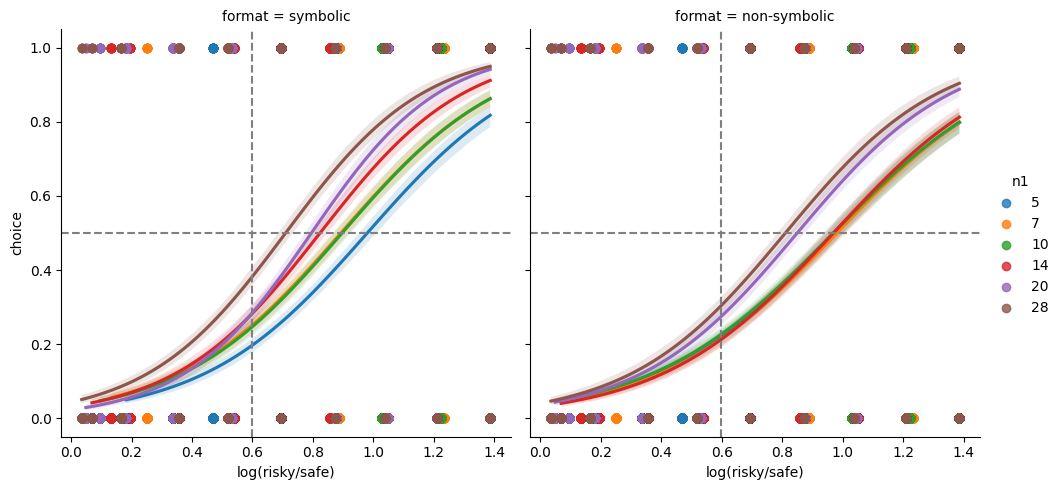

In [5]:
x_var = 'log(risky/safe)'
fig = sns.lmplot(df_mig.reset_index(), x=x_var, y='choice', hue= 'n1', col='format',ci=95,  logistic=True)

for ax in fig.axes.flat:
    ax.axvline(x=np.log(1/0.55),color='grey', ls='--')
    ax.axhline(y=0.5,color='grey', ls='--')

In [67]:
# for my data

from utils import get_data

df = get_data()


number of subjects found: 66


In [68]:
subList = [1,2,3,4,5,6,7,8,9,10]
df = df.loc[df.index.get_level_values('subject').isin(subList)] # only 10 subs to check model fitting
df = df.xs('symbolic', 0, 'format')

df.head()

choice    n1    n2  prob1  prob2  risky_left  \
subject session trial_nr                                                 
8       1       2          False  14.0  10.0   0.55    1.0        True   
                3           True  33.0  28.0   0.55    1.0        True   
                4          False  66.0  28.0   0.55    1.0        True   
                5           True  28.0  14.0   0.55    1.0        True   
                6           True  23.0  10.0   0.55    1.0        True   

                          chose_risky  n_risky  n_safe      frac  \
subject session trial_nr                                           
8       1       2                True     14.0    10.0  1.400000   
                3               False     33.0    28.0  1.178571   
                4                True     66.0    28.0  2.357143   
                5               False     28.0    14.0  2.000000   
                6               False     23.0    10.0  2.300000   

                          log(risky/safe)   log(n1) bin(risky/safe)    p1  \
subject session trial_nr                                                    
8       1       2                0.336472  2.639057             32%  0.55   
                3                0.164303  3.496508             20%  0.55   
                4                0.857450  4.189655             56%  0.55   
                5                0.693147  3.332205             44%  0.55   
                6                0.832909  3.135494             56%  0.55   

                           p2  group  
subject session trial_nr              
8       1       2         1.0    1.0  
                3         1.0    1.0  
                4         1.0    1.0  
                5         1.0    1.0  
                6         1.0    1.0

In [69]:
df['n1'] = df['n_safe']
df['n2'] = df['n_risky']
df['p1'] = 1
df['p2'] = 0.55

df['choice'] = df['chose_risky']
df['log(n2/n1)'] = np.log(df['n2'] / df['n1'])

df = df[df_mig.columns.values]
df.head()


p1    n1    p2    n2  log(risky/safe)  choice
subject session trial_nr                                               
8       1       2          1  10.0  0.55  14.0         0.336472    True
                3          1  28.0  0.55  33.0         0.164303   False
                4          1  28.0  0.55  66.0         0.857450    True
                5          1  14.0  0.55  28.0         0.693147   False
                6          1  10.0  0.55  23.0         0.832909   False

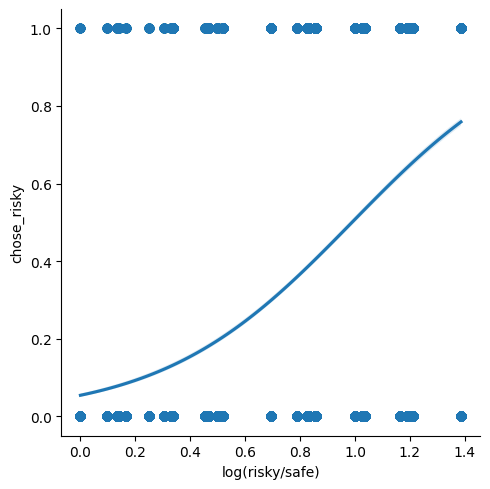

In [62]:
g = sns.lmplot(df.reset_index(), x='log(risky/safe)', y='choice', ci=95,  logistic=True) #  hue='format',


## fit model

In [74]:
model = RiskLapseModel(data=df, prior_estimate='klw', fit_seperate_evidence_sd=False)

In [75]:
model.build_estimation_model()

In [76]:
idata = model.sample(1000, 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [evidence_sd_mu_untransformed, evidence_sd_sd, evidence_sd_offset, prior_sd_mu_untransformed, prior_sd_sd, prior_sd_offset, p_lapse_mu_untransformed, p_lapse_sd, p_lapse_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### posterior estimates

In [ ]:
from bauer.utils.plotting import plot_subjectwise_parameters
plot_subjectwise_parameters(idata, parameter='evidence_sd')

In [ ]:
plot_subjectwise_parameters(idata, parameter='p_lapse')

In [ ]:
def get_rnp(evidence_sd, prior_std, p=.55):
    beta = prior_std**2 / (evidence_sd**2 + prior_std**2)
    return np.clip(np.exp(-(1./beta) * np.log(1./p)), 0, 1)

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

plot_subjectwise_parameters(idata, parameter='rnp')

## PPCs

In [77]:
ppc = model.ppc(df, idata)

Sampling: [ll_bernoulli]


In [78]:
from bauer.utils.plotting import plot_ppc, summarize_ppc, plot_prediction, cluster_offers
import matplotlib.pyplot as plt

In [79]:
df['log(n2/n1)'] = np.log(df['n2'] / df['n1'])

In [80]:

def plot_ppc(df, ppc, exp_type='magnitude', plot_type=1, var_name='p', level='subject', col_wrap=5, n_clusters=13):

    if exp_type  == 'magnitude':
        x = 'log(n2/n1)'

        if 'log(n2/n1)' not in ppc.index.names:
            if 'frac'  in ppc.index.names:
                ppc['log(n2/n1)'] = np.log(ppc.index.get_level_values('frac'))
            else:
                ppc['log(n2/n1)'] = np.log(ppc.index.get_level_values('n2')) - np.log(ppc.index.get_level_values('n1'))

            ppc.set_index('log(n2/n1)', append=True)

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()


    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', x]).size().groupby('subject').size() < (n_clusters+1)).all():
        if level == 'subject':
            df[x] = df.groupby(['subject'],
                                            group_keys=False).apply(lambda d: cluster_offers(d, n_clusters, x))
        else:
            df[x] = cluster_offers(df, n_clusters, x)

    if plot_type == 0:
        groupby = [x]
    elif plot_type == 1:
        groupby = [x, 'n1']
    elif plot_type == 2:
        groupby = ['n1']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby).mean()[['choice']]
    ppc_summary = ppc_summary.join(p, how='outer').reset_index()

    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'choice')

    elif plot_type in [1]:
        fac = sns.FacetGrid(ppc_summary,
                            hue='n1',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'choice')

    if plot_type in [2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x='n1')
        fac.map(plt.scatter, 'n1', 'choice')
    
    fac.add_legend()

    return fac

/Users/mrenke/git/bauer/bauer/utils/bayes.py:38: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


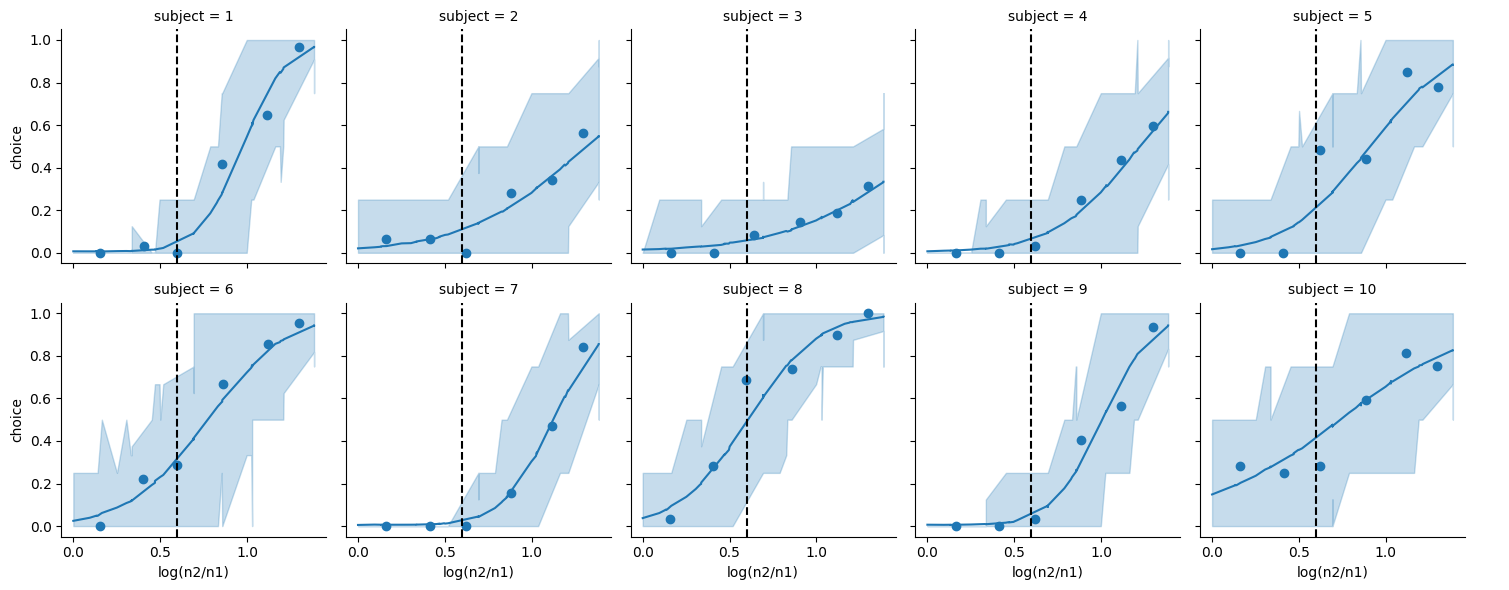

In [81]:
g = plot_ppc(df, ppc, var_name='ll_bernoulli', plot_type=0, level='subject', n_clusters=6)

g.map(plt.axvline, x=np.log(1./0.55), c='k', ls='--')

In [41]:
df.head()

choice    n1    n2  prob1  prob2  risky_left  \
subject session trial_nr                                                 
8       1       2          False  10.0  14.0   0.55    1.0        True   
                3           True  28.0  33.0   0.55    1.0        True   
                4          False  28.0  66.0   0.55    1.0        True   
                5           True  14.0  28.0   0.55    1.0        True   
                6           True  10.0  23.0   0.55    1.0        True   

                          chose_risky  n_risky  n_safe      frac  \
subject session trial_nr                                           
8       1       2                True     14.0    10.0  1.400000   
                3               False     33.0    28.0  1.178571   
                4                True     66.0    28.0  2.357143   
                5               False     28.0    14.0  2.000000   
                6               False     23.0    10.0  2.300000   

                          log(risky/safe)   log(n1) bin(risky/safe)    p1  \
subject session trial_nr                                                    
8       1       2                0.336472  2.639057             32%  0.55   
                3                0.164303  3.496508             20%  0.55   
                4                0.857450  4.189655             56%  0.55   
                5                0.693147  3.332205             44%  0.55   
                6                0.832909  3.135494             56%  0.55   

                           p2  group  log(n2/n1)  
subject session trial_nr                          
8       1       2         1.0    1.0    0.336472  
                3         1.0    1.0    0.164303  
                4         1.0    1.0    0.857450  
                5         1.0    1.0    0.693147  
                6         1.0    1.0    0.832909

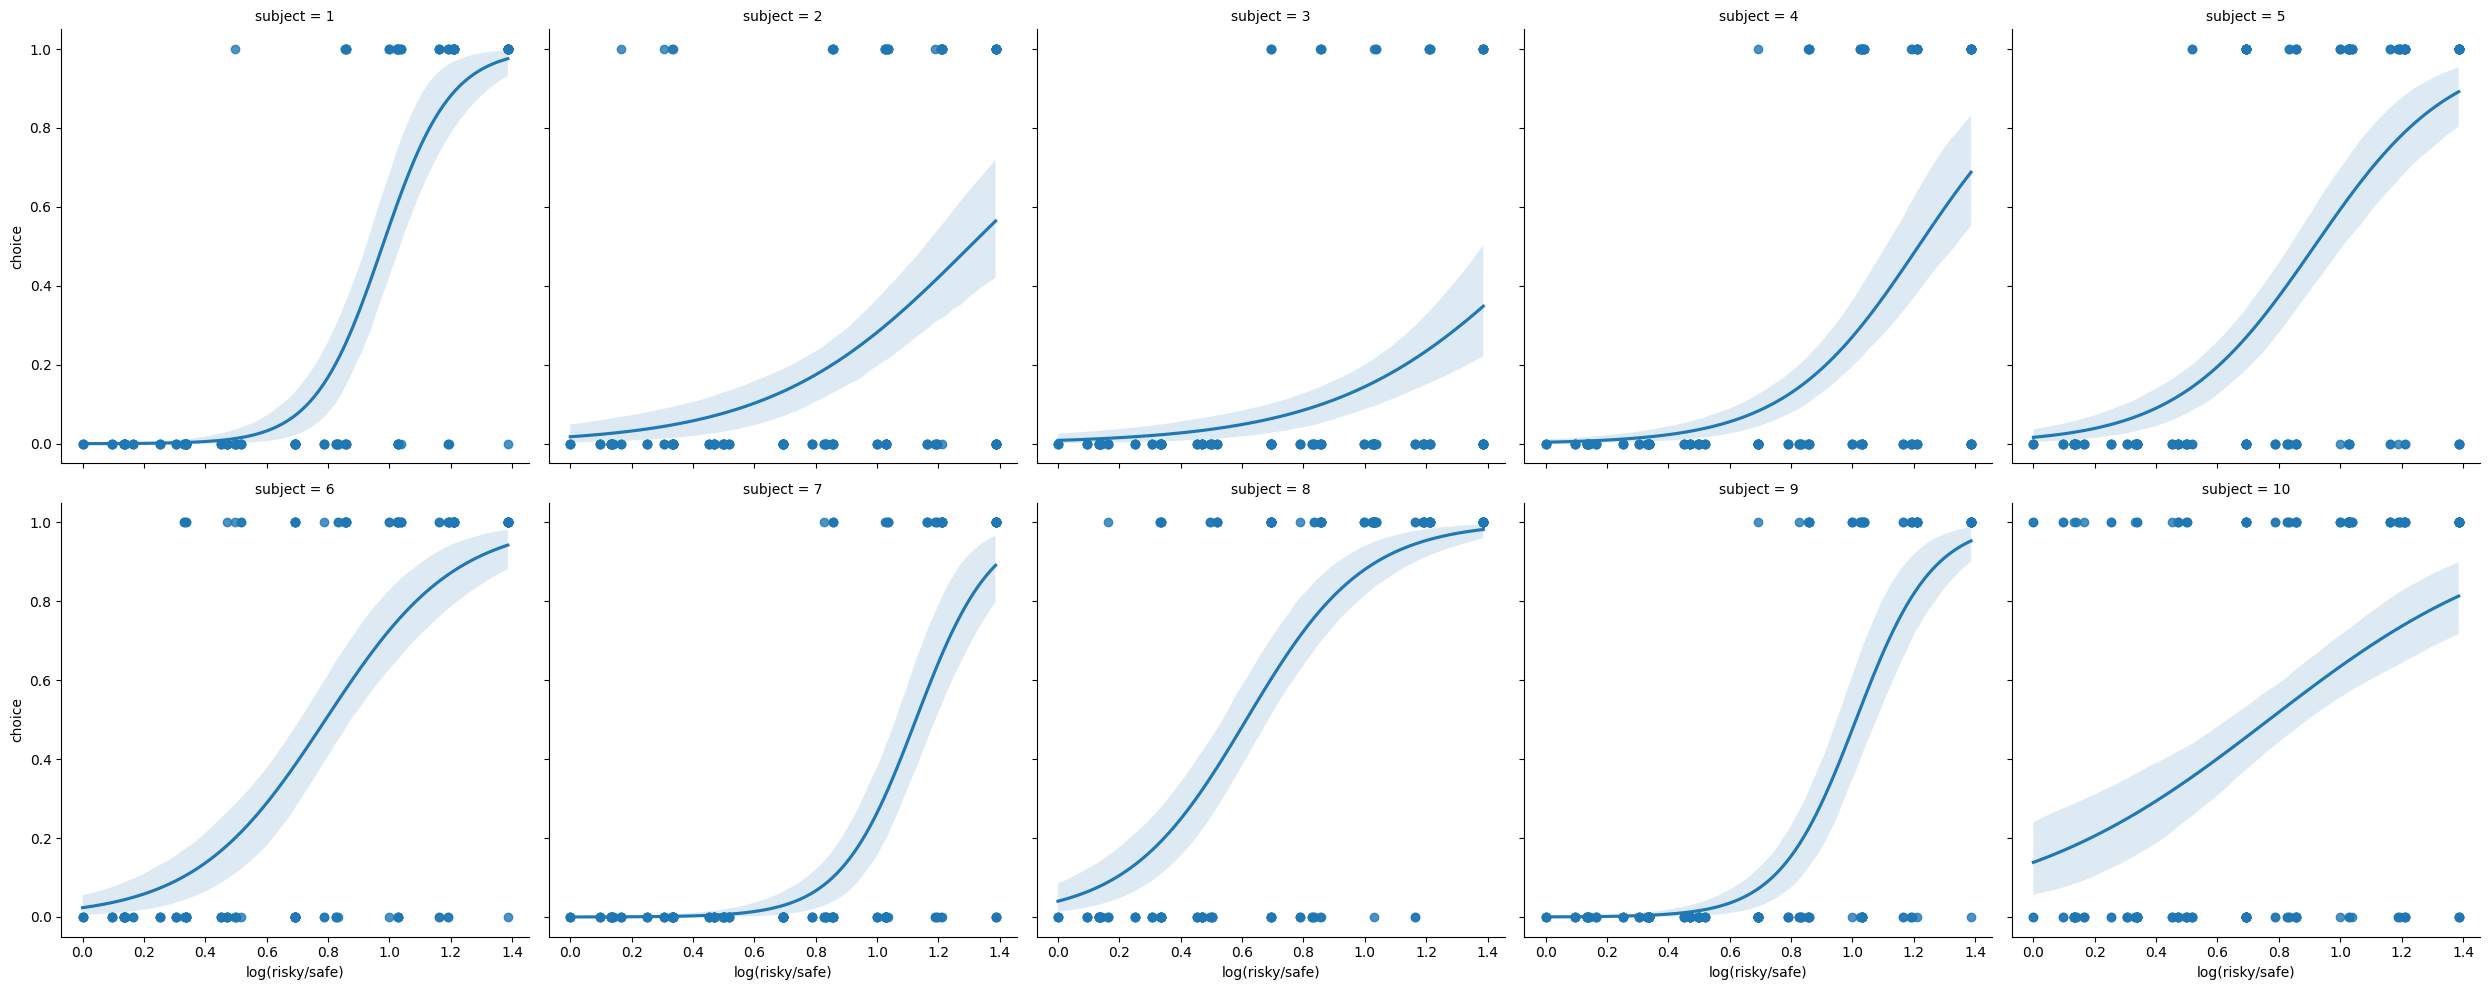

In [73]:

g = sns.lmplot(df.reset_index(), x='log(risky/safe)', y='choice', col='subject',ci=95,  logistic=True, col_wrap=5) #  hue='format',
